In [1]:
%config IPCompleter.greedy=True
%matplotlib inline


import torch
import os
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import itertools
import math
import pandas as pd
import unicodedata
import codecs
import itertools



import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

CUDA = torch.cuda.is_available()
# device = torch.device("cuda" if CUDA else "cpu")
device = torch.device("cuda")

# DATA


leave out validation set

In [3]:
INPUT_SIZE = 2500


xy = pd.read_csv('./prep_student_input.csv')
z = pd.read_csv('./word_translations.csv')

translations = {z['Italian'][i]: z['English'][i] for i in range(len(z))}

randomindexes = [random.randint(0, INPUT_SIZE) for _ in range(INPUT_SIZE)]

prep = [xy['Prep']]

pastconvo = [xy['Prep'][randomindexes[i]]+' '+xy['Obj'][randomindexes[i]] +' '+ xy['Color'][randomindexes[i]] +' '+ xy['Past Convo'][randomindexes[i]] for i in range(len(randomindexes))]

response = [xy['Tutor Response'][randomindexes[i]] for i in range(len(randomindexes))]


#' '.join(pastconvo[i].split()[TOKENS_TAKEN:])
pairs = [[pastconvo[i], response[i]] for i in range(len(pastconvo))]

print("input data selected")

input data selected


# VOCABUOLARY


In [4]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold # CHANGE probably shouldn't do this
    def trim(self, min_count):
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)        
        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))
        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [5]:
# make data simple
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [6]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# creating vocab


In [7]:
pairs = [[normalizeString(line) for line in p] for p in pairs]


pastwhole = pd.DataFrame(data=xy['Past Convo']).values.flatten().tolist()
tutorwhole = pd.DataFrame(data=xy['Tutor Response']).values.flatten().tolist()

pairs_whole = [[pastwhole[i], tutorwhole[i]] for i in range(len(pastwhole))]

pairs_whole = [[normalizeString(line) for line in p] for p in pairs_whole]

voc = Vocabulary("dialog")



#getting  rid of rare words
for pair in pairs_whole:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
print("counted words:", voc.num_words)
print("vocabulary created")


counted words: 1014
vocabulary created


# prepare data

In [8]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


In [9]:
#make column consistent and transpose
def zeroPadding(l, fillvalue= 0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [10]:
def binaryMatrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

In [11]:
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len, input_batch, output_batch

# MODEL

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

Attention using dot

In [13]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        attn_energies = self.dot_score(hidden, encoder_outputs)
        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()
        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [14]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

# EVAL

In [15]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores
    

In [16]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words, scores


#returns a list of output words fiven a input sentence
def evaluateInput(encoder, decoder, searcher, voc, input_sentence, max_length):
    input_sentence = normalizeString(input_sentence)
    # Evaluate sentence
    output_words, scores = evaluate(encoder, decoder, searcher, voc, input_sentence, max_length)
    # Format and print response sentence
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    return output_words, scores
#     print('Bot:', ' '.join(output_words))

def evaluate_with_target(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE):

    randomindexes = [random.randint(INPUT_SIZE, len(xy['Past Convo'])) for _ in range(TEST_SIZE)]

    inputs = [xy['Past Convo'][randomindexes[i]] for i in range(TEST_SIZE)]
    targets = [xy['Tutor Response'][randomindexes[i]] for i in range(TEST_SIZE)]

    for i in range(TEST_SIZE):
        max_length = len(normalizeString(targets[i]).split()) 
        print("past convo:", inputs[i])
        print("\n")

        output_words, scores = evaluateInput(encoder, decoder, searcher, voc, inputs[i], max_target_len)
        print('Bot:', ' '.join(output_words))
        print("\n")
        print("Correct: ", targets[i])
        print("\n")
        
def validation_eval(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE):

    randomindexes = [random.randint(INPUT_SIZE, len(xy['Past Convo'])) for _ in range(TEST_SIZE)]

    inputs = [xy['Past Convo'][randomindexes[i]] for i in range(TEST_SIZE)]
    targets = [xy['Tutor Response'][randomindexes[i]] for i in range(TEST_SIZE)]
    
    scores = []  
    for i in range(TEST_SIZE):
        max_length = len(normalizeString(targets[i]).split()) 
        print("past convo:", inputs[i])
        print("\n")

        output_words, scorelist = evaluateInput(encoder, decoder, searcher, voc, inputs[i], max_target_len)
        scores.append(sum(scorelist)/len(scorelist))
        print('Bot:', ' '.join(output_words))
        print("\n")
        
    return sum(scores)/len(scores)


# simulated student

In [17]:
import  pprint
pp = pprint.PrettyPrinter(indent = 4)


z = pd.read_csv('./word_translations.csv')
translations = {z['Italian'][i]: z['English'][i] for i in range(len(z))}
translations_toItalian = {z['English'][i]: z['Italian'][i] for i in range(len(z))}

concepts = list(translations.keys())
prep = concepts[:8]
color = concepts[8:16]
obj = concepts[16:]

def concept(word):
    if iseng(word):
        return translations_toItalian[word]
    else:
        return word

def iseng(word):
    if word in translations_toItalian.keys():
        return True
    else:
        return False

def isitalian(word):
    if word in translations.keys():
        return True
    else:
        return False

#guess is list in correct order, correct is solution list
def identify_incorrects(guess, correct):
    rv = []
    for i in range(len(correct)):
        if guess[i] != correct[i]:
            rv.append(correct[i])
    return rv
        
    

In [18]:

#correct order is prep obj color


class Student:
    def __init__(self, pickup, forget):
        global prep,color,obj
        self.pickup = pickup
        self.forget = forget
        self.knowledge = {
            "prep": {p: random.random() for p in prep},
            "color": {c: random.random() for c in color},
            "obj": {o: random.random() for o in obj}
        }
       
    #TODO: can output random italian word too
    #output three words in correct order list
    def guess(self, correct):
        global translations
        #correct: [prep, object, color]
        prep_c, obj_c, color_c = correct
        prep_t = translations[prep_c]
        obj_t = translations[obj_c]
        color_t = translations[color_c]
        
#         rv = 'is it '
        rv = []
        rv.append(prep_c) if self.knowledge["prep"][prep_c] > 0.7 else rv.append(prep_t)
        rv.append(obj_c)  if self.knowledge["obj"][obj_c] > 0.7 else rv.append(obj_t)
        rv.append(color_c) if self.knowledge["color"][color_c] > 0.7 else rv.append(color_t)
        return rv
    
    #returns empty string if nothing to ask
    #returns the eng word
    def ask(self, correct):
        #TODO: randomize order
        #correct = [prep_c, obj_c, color_c]
        global translations
        word = ''
        prep_c, obj_c, color_c = correct
        
        if self.knowledge["prep"][prep_c] < 0.3:
            word = prep_c
        elif self.knowledge["obj"][obj_c] <  0.3:
            word = obj_c
        elif self.knowledge["color"][color_c] < 0.3:
            word = color_c
        
        if word != '':
            #rv = 'How do i say ' + translations[word] + ' in Italian'
            rv = translations[word]
        else:
            rv = ''
        return rv
    #forgets concepts that is not mentioned for each tutor response, excluding  gained
#     def forget(self, gained):
        
    def pickout_concepts(self, output_words):
        #return all concepts (only in italian)
        rv = []
        for word in output_words:
            if isitalian(word):
                rv.append(word)
            elif iseng(word):
                rv.append(concept(word))
        return list(set(rv))
    
    def pickout_relevent_concepts(self, output_words, correct):
        #all concepts in italian
        concepts = self.pickout_concepts(output_words)
        return [x for x in concepts if x in correct]
                
    def change_knowledge(self, output_words, correct):
        #pick out knowledge
        global prep,color,obj
        concepts = self.pickout_relevent_concepts(output_words, correct)
        p = []
        o = []
        c=  []
        for word in concepts:
            if word in prep:
                p.append(word)
            elif word in color:
                c.append(word)
            elif word in obj:
                o.append(word)
        order = ["prep", "obj", "color"]  
        groups = [p, o, c]
        change = 0
        
        #update knowledge and return change
        #TODO only forget things that are not mentioned 
        for i in range(3):
            for c in groups[i]:
                if self.knowledge[order[i]][c] < 1:
                    self.knowledge[order[i]][c] = 1
                    change +=1
#                     if random.random() < self.pickup: 
#                         self.knowledge[order[i]][c] = min(self.knowledge[order[i]][c]+0.4, 1)
#                         change += 1   

        return change




In [19]:

def penalty(output_words, student, studentexpect, correct, incorrects):
    concepts = student.pickout_concepts(output_words)
    relevent = student.pickout_relevent_concepts(output_words, correct)
    #TODO relevent includes english and italian
    
    #if nothing correct but confirmed could be because ordering or grammar
    
    #conditional on student answer
    # 1 => penalize
    # 0 => reward
    
    #incorrect = list incorrect concepts in italian
    if len(incorrects) == 0 and studentexpect == '':
        if 'correct' not in output_words or 'yes' not in output_words:
            print("penalize: student was correct but no confirmation")
            return 1
        else:
            print("reward: correct")
            return 0.2
    elif studentexpect != '':
        #TODO need both eng and italian 
        if studentexpect in relevent:
            print("reward: answered question")
            return 0.2
        else:
            print("penalize: didn't answer question")
            return 1
    else:
        #the student made a guess that's incorrect 
        if len(incorrects) == 3 and 'correct' in output_words:
            print("penalize: all wrong but said correct")
            return 1
        if concepts == []:
            #maybe made a grammar hint
            print("neutral: did not make a word hint")
            return 0.8
        elif len(concepts) != len(relevent):
            print("penalize: had irrelevent hints")
            return 1
        else:
            #needs to be a hint that student got incorrect
            for hint in relevent:
                if hint not in incorrects:
                    print("penalize: not a hint that student got wrong")
                    return 1
            print("reward: is a hint student got wrong")
            return 0.2
        
    
    
    

In [20]:

# start one eval
def simulate_with_student(encoder, decoder, searcher, voc):
# one conversation
    student = Student(1,0)
    tutor_score = 0
    studentexpect = ''
    guess_incorrects = []
    prep_c =  random.choice(prep)
    color_c = random.choice(color)
    obj_c = random.choice(obj)
    correct = [prep_c, obj_c, color_c]
    print(correct)
    
    #TODO: while student not correct or expects answer
    for i in range(5):
        coin = random.random()
        if coin < 0.5 and student.ask(correct) != '':
            askeng = student.ask(correct)
            studentexpect = translations_toItalian[askeng]
            input_sent = 'How do you say ' + askeng + ' in Italian'
        else:
            guess = student.guess(correct)
            guess_incorrects = identify_incorrects(guess, correct)
            input_sent = "is it "+ guess[0] + " " + guess[1] + " " + guess[2]
        
        print('\n')
        print('Student:', input_sent)
        print('incorrect:', guess_incorrects)
        print('expect:', studentexpect)

        #evaluate on model
        output_words,scores = evaluateInput(encoder, decoder, searcher, voc, input_sent, max_target_len)
        output = ' '.join(output_words)
        #evaluate on input
#         output = input('> ')
#         if output == 'q' or output == 'quit': break
#         output_words = output.split()
        
        #how many concpets changed
        change = student.change_knowledge(output_words, correct)
        
        #change tutor score
        tutor_score += penalty(output_words, student, studentexpect, correct, guess_incorrects)

        print('Bot:', output)
        print('pickout concpets:', student.pickout_concepts(output_words))
        print('change:', change)
        #TODO: tutor_score
        print('penalty', tutor_score)  
        studentexpect = ''
        guess_incorrects = []
        
    return tutor_score
    
    

# test train with input

In [21]:

#simulate_with_student(encoder, decoder, searcher, voc)
# simulate_with_student(voc)

# TRAIN

In [22]:
# negative log lokelihood loss
# maskNLLLoss(decoder_output, target_variable[t], mask[t])
def maskNLLLoss(inp, target, mask): 
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    #loss = reward * loss -> 0.001/1
#     loss = loss * tutor_score
    loss = loss.to(device)
    return loss, nTotal.item()


input_variable: tensor([[ 32,  32,  32,  ...,  32,  32,  32],
        [143,  33,  90,  ..., 135,  33,  33],
        [144, 136,  67,  ..., 136, 136, 136],
        ...,
        [111,   0,   0,  ...,   0,   0,   0],
        [ 78,   0,   0,  ...,   0,   0,   0],
        [  2,   0,   0,  ...,   0,   0,   0]])
lengths: tensor([139, 109,  76,  75,  68,  68,  64,  62,  61,  59,  58,  56,  54,  53,
         48,  48,  44,  42,  40,  35,  30,  30,  29,  29,  27,  26,  26,  24,
         23,  22])
target_variable: tensor([[114,  63, 246,  19,   9,  13, 213, 113,  45, 364, 119,   4, 105, 125,
         114, 218,  63,  17,  35,  75,  19,   5,  32,  13, 154, 114,  32, 119,
         413,   5],
        [116, 114,   7,   5,  10,  38,   5, 116,  78,  78, 105,   5,  47,   5,
         760,   5, 312,   5,   5,   5,   5,  30,  33,  38,   5,   7,  33,  13,
           7,  30],
        [ 63, 161,  13,  23,  11, 124, 214, 125,   2, 188, 149,   6, 364, 141,
          13,  35,  46, 132,  13,  76,  23,   5,  34, 124,

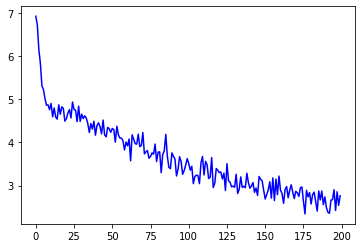

 Iteration: 201
returned loss 2.3855845508410165


 Iteration: 202
returned loss 2.530046160004779


 Iteration: 203
returned loss 2.4672979170437057


 Iteration: 204
returned loss 2.5446676466218086


 Iteration: 205
returned loss 3.0286052329465747


 Iteration: 206
returned loss 2.7288660803150577


 Iteration: 207
returned loss 2.5775931950597823


 Iteration: 208
returned loss 2.5315474357717394


 Iteration: 209
returned loss 2.403708280944457


 Iteration: 210
returned loss 2.728874788727415


 Iteration: 211
returned loss 2.603554541013794


 Iteration: 212
returned loss 2.2185426791845932


 Iteration: 213
returned loss 2.9970388153210434


 Iteration: 214
returned loss 2.6987819829457242


 Iteration: 215
returned loss 2.5216576234125365


 Iteration: 216
returned loss 2.4450359020231143


 Iteration: 217
returned loss 2.2572448940898076


 Iteration: 218
returned loss 2.3386772312981083


 Iteration: 219
returned loss 2.433626125647646


 Iteration: 220
returned loss 2.6424

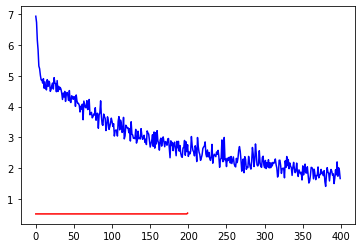

 Iteration: 401
returned loss 2.043127016528513


 Iteration: 402
returned loss 1.8316945851495203


 Iteration: 403
returned loss 1.7178337053279784


 Iteration: 404
returned loss 1.602637723279632


 Iteration: 405
returned loss 1.5534599400185145


 Iteration: 406
returned loss 1.656907971915655


 Iteration: 407
returned loss 1.714097344222917


 Iteration: 408
returned loss 2.0076547043247808


 Iteration: 409
returned loss 1.6717333872311155


 Iteration: 410
returned loss 1.7152838176589902


 Iteration: 411
returned loss 1.4142443419465522


 Iteration: 412
returned loss 1.5581282526058997


 Iteration: 413
returned loss 1.5969750437707577


 Iteration: 414
returned loss 1.8109197423069014


 Iteration: 415
returned loss 1.4322771940866146


 Iteration: 416
returned loss 1.7782610020971064


 Iteration: 417
returned loss 1.489555669517722


 Iteration: 418
returned loss 1.39982552005305


 Iteration: 419
returned loss 1.9244857468787646


 Iteration: 420
['accanto', 'gatto', '

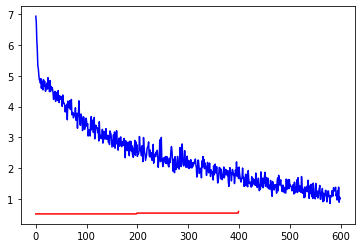

 Iteration: 601
returned loss 1.1090438334408832


 Iteration: 602
returned loss 1.0117046315747165


 Iteration: 603
returned loss 0.7993084141112959


 Iteration: 604
returned loss 0.9865389378060161


 Iteration: 605
returned loss 1.0031235532596168


 Iteration: 606
returned loss 1.1221623073696443


 Iteration: 607
returned loss 1.0292825979221127


 Iteration: 608
returned loss 1.427466738238258


 Iteration: 609
returned loss 1.106732832657888


 Iteration: 610
returned loss 1.1740166523730295


 Iteration: 611
returned loss 1.4013917402014622


 Iteration: 612
returned loss 1.1218707651081843


 Iteration: 613
returned loss 1.1061624928305929


 Iteration: 614
returned loss 1.0557373959485343


 Iteration: 615
returned loss 0.9848811491195543


 Iteration: 616
returned loss 0.9897057809433198


 Iteration: 617
returned loss 1.0116618966089728


 Iteration: 618
returned loss 0.9602410180698121


 Iteration: 619
returned loss 1.0975038021099603


 Iteration: 620
['dietro', 'scato

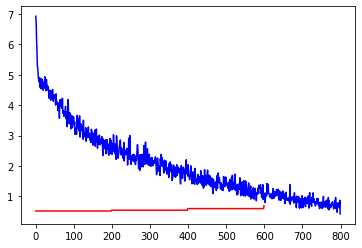

 Iteration: 801
returned loss 0.7006504319212168


 Iteration: 802
returned loss 0.8294725398569878


 Iteration: 803
returned loss 0.6041349938632308


 Iteration: 804
returned loss 0.8045489982485977


 Iteration: 805
returned loss 0.5662075749354358


 Iteration: 806
returned loss 0.7292671593740679


 Iteration: 807
returned loss 0.7801107252823155


 Iteration: 808
returned loss 0.7684929434863902


 Iteration: 809
returned loss 0.574912580415298


 Iteration: 810
returned loss 0.6258103518508774


 Iteration: 811
returned loss 0.7063732249992689


 Iteration: 812
returned loss 0.5260626123564971


 Iteration: 813
returned loss 0.7359663722802396


 Iteration: 814
returned loss 0.6382613748721275


 Iteration: 815
returned loss 0.7784389695037662


 Iteration: 816
returned loss 0.6186748960019905


 Iteration: 817
returned loss 0.5752119758197417


 Iteration: 818
returned loss 0.8523477920857245


 Iteration: 819
returned loss 0.7227148636575844


 Iteration: 820
['vicino', 'bors

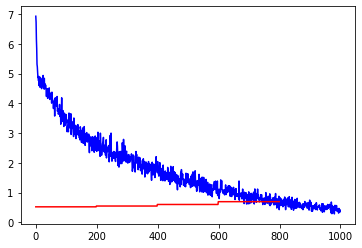

 Iteration: 1001
returned loss 0.34545393585864814


 Iteration: 1002
returned loss 0.4285047694887799


 Iteration: 1003
returned loss 0.4838488467225255


 Iteration: 1004
returned loss 0.38744127603632883


 Iteration: 1005
returned loss 0.3312765137833104


 Iteration: 1006
returned loss 0.3552296408285786


 Iteration: 1007
returned loss 0.4054239411892805


 Iteration: 1008
returned loss 0.44798073338221617


 Iteration: 1009
returned loss 0.4549720311598914


 Iteration: 1010
returned loss 0.3339428236964398


 Iteration: 1011
returned loss 0.3136211181694658


 Iteration: 1012
returned loss 0.4944443618341421


 Iteration: 1013
returned loss 0.49998425057879525


 Iteration: 1014
returned loss 0.388543863446341


 Iteration: 1015
returned loss 0.3549606927569441


 Iteration: 1016
returned loss 0.34273680602085227


 Iteration: 1017
returned loss 0.44445450940817327


 Iteration: 1018
returned loss 0.4738059134945027


 Iteration: 1019
returned loss 0.4920166185541997


 Iterat

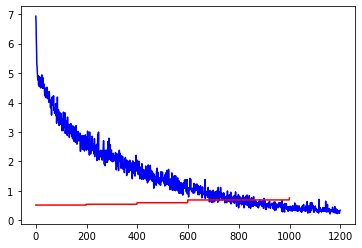

 Iteration: 1201
returned loss 0.3485298288774075


 Iteration: 1202
returned loss 0.3078311882569256


 Iteration: 1203
returned loss 0.2965684349546414


 Iteration: 1204
returned loss 0.3061526517404867


 Iteration: 1205
returned loss 0.27971122109903745


 Iteration: 1206
returned loss 0.38342822295674533


 Iteration: 1207
returned loss 0.2588333512672043


 Iteration: 1208
returned loss 0.31417193438807023


 Iteration: 1209
returned loss 0.2882031337669189


 Iteration: 1210
returned loss 0.34703852179646105


 Iteration: 1211
returned loss 0.2720985825045757


 Iteration: 1212
returned loss 0.2652471126549032


 Iteration: 1213
returned loss 0.31987640655869337


 Iteration: 1214
returned loss 0.2686351304591512


 Iteration: 1215
returned loss 0.30500076203262994


 Iteration: 1216
returned loss 0.42701974022951245


 Iteration: 1217
returned loss 0.2629749665111194


 Iteration: 1218
returned loss 0.25236709496840287


 Iteration: 1219
returned loss 0.2556057073463986


 Ite

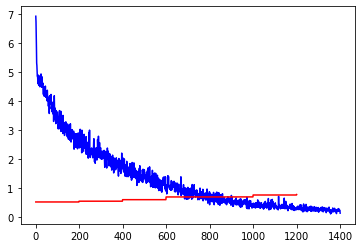

 Iteration: 1401
returned loss 0.28997862788183154


 Iteration: 1402
returned loss 0.1866640689382394


 Iteration: 1403
returned loss 0.2315076647633336


 Iteration: 1404
returned loss 0.18682996823984574


 Iteration: 1405
returned loss 0.1816216094860237


 Iteration: 1406
returned loss 0.31529837855478365


 Iteration: 1407
returned loss 0.18920059840012796


 Iteration: 1408
returned loss 0.22452243552926363


 Iteration: 1409
returned loss 0.20307141789310723


 Iteration: 1410
returned loss 0.2718051001569941


 Iteration: 1411
returned loss 0.1473332605469218


 Iteration: 1412
returned loss 0.2355465131726421


 Iteration: 1413
returned loss 0.2500687076449067


 Iteration: 1414
returned loss 0.24648367023514972


 Iteration: 1415
returned loss 0.18332007681003512


 Iteration: 1416
returned loss 0.2486656248152132


 Iteration: 1417
returned loss 0.1817546155911842


 Iteration: 1418
returned loss 0.2272946807051694


 Iteration: 1419
returned loss 0.21041785140006794


 It

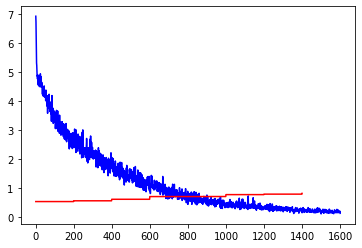

 Iteration: 1601
returned loss 0.2278175628334871


 Iteration: 1602
returned loss 0.18994406294440488


 Iteration: 1603
returned loss 0.13972681405532394


 Iteration: 1604
returned loss 0.20173154730559933


 Iteration: 1605
returned loss 0.22750922044967106


 Iteration: 1606
returned loss 0.22859489027954016


 Iteration: 1607
returned loss 0.19786463411442273


 Iteration: 1608
returned loss 0.15852207853005257


 Iteration: 1609
returned loss 0.19998721109514184


 Iteration: 1610
returned loss 0.2269579544295198


 Iteration: 1611
returned loss 0.13503995482200318


 Iteration: 1612
returned loss 0.19710563407975412


 Iteration: 1613
returned loss 0.24473989388724463


 Iteration: 1614
returned loss 0.15767429532139648


 Iteration: 1615
returned loss 0.2589174925366019


 Iteration: 1616
returned loss 0.20229001920759088


 Iteration: 1617
returned loss 0.20979643424360309


 Iteration: 1618
returned loss 0.24555248538677443


 Iteration: 1619
returned loss 0.2569709387813014

KeyboardInterrupt: 

In [23]:
LEARN_RATE = 0.001
clip = 50.0
# num_iters = 400
DESIRED_LOSS = 0.1

small_batch_size = 30
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len, input_batch, output_batch = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

attn_model = 'dot'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
embedding = nn.Embedding(voc.num_words, hidden_size)

encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model,  embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
#pass models to device 
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.train()
decoder.train()

#optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARN_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARN_RATE)
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()


# start training
print("START TRAINING")
print("\n")

returned_losses = []
validation_losses = []
searcher = GreedySearchDecoder(encoder, decoder)
TEST_SIZE = 30

iteration = 0
# for iteration in range(num_iters):
while iteration < 2800:
    iteration += 1
    
    print(" Iteration:", iteration)
    
    batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
    input_variable, lengths, target_variable, mask, max_target_len, input_batch, output_batch = batches
    
    #train one iter
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    loss = 0
    print_losses = []
    n_totals = 0
    

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
#     print("encoder output shape", encoder_outputs.shape)
#     print("last encoder hidden shape", encoder_hidden.shape)

    decoder_input = torch.LongTensor([[SOS_token for _ in range (small_batch_size)]])
    decoder_input = decoder_input.to(device)
#     print("initial decoder input shape", decoder_input.shape)
#     print(decoder_input)

    decoder_hidden =  encoder_hidden[:decoder.n_layers]
#     print("initial decoder hidden state shape", decoder_hidden.shape)

    for t in range(max_target_len):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)

        #teacher forcing
        decoder_input = target_variable[t].view(1,-1)

        mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
        loss += mask_loss
        print_losses.append(mask_loss.item() * nTotal)

        n_totals += nTotal
        
    #simulated student eval
    
    if iteration > 300 and iteration % 20 == 0:
        encoder.eval()
        decoder.eval()

        searcher = GreedySearchDecoder(encoder, decoder)
        tutor_score = simulate_with_student(encoder, decoder, searcher, voc)
        encoder.train()
        decoder.train()

        loss = loss * tutor_score / 5
        returned_loss = sum(print_losses) / n_totals * tutor_score / 5
    else:
        returned_loss = sum(print_losses) / n_totals
        
    loss.backward(retain_graph=True)
    
    
    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    
    returned_losses.append(returned_loss)
    
    
    
    print("returned loss", returned_loss)
#     print(returned_losses)
    print("\n")
    
    if iteration % 200 == 0:
        encoder.eval()
        decoder.eval()
        valid_loss = validation_eval(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE)
        encoder.train()
        decoder.train()
    if iteration > 200:
        validation_losses.append(valid_loss)
    
    if iteration % 200 == 0:   
        plt.plot(returned_losses, color='blue')
        plt.plot(validation_losses, color='red')
        plt.show()



EVALUATION on validation set

In [ ]:
TEST_SIZE = 30

encoder.eval()
decoder.eval()

searcher = GreedySearchDecoder(encoder, decoder)

evaluate_with_target(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE)

VALIDATION working train iter


In [ ]:

    
# random.seed(8022019)
LEARN_RATE = 0.001
clip = 50.0
# num_iters = 400

small_batch_size = 20

# Katie's pseudocode for tuning hyperparameters.
# hidden_options = [128, 256, 512, 1024]
# layer_options = [1,2]
# batch_options = [4, 8, 16, 32, 64]
# best_valid_loss = current_Running_best_loss (starts at inf or 1000000)
# for combination in zippedlist_ofoptions:
#     train_model()
#     if valid_loss < best_valid_loss:
#         best_model = model.deepcopy()

# best_model will be the best model! :D


#Change learning rates in tuning as well

#integrate learning rate decay - every "n" steps, multiply by 0.5
#reference code for this: optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# taken from : https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch

#switch GRU to LSTM or Transformer

#how often to update with the student simulation - try different combinations and compare with valid loss

#beam search https://medium.com/the-artificial-impostor/implementing-beam-search-part-1-4f53482daabe OR if you want to be fancy, nucleus sampling https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317 and https://arxiv.org/pdf/1904.09751.pdf
    
attn_model = 'dot'
hidden_size = 256
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
embedding = nn.Embedding(voc.num_words, hidden_size)

encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model,  embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
#pass models to device 
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.train()
decoder.train()

#optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARN_RATE, weight_decay=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARN_RATE, weight_decay=0.001)
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()



# start training
print("START TRAINING")
print("\n")

returned_losses = []
validation_losses = []
tutor_scores = []
searcher = GreedySearchDecoder(encoder, decoder)
TEST_SIZE = 30

#predefine eval set
# randomindexes = [random.randint(INPUT_SIZE, len(pastconvo)) for _ in range(TEST_SIZE)]
# evalset = [pairs[randomindexes[i]] for i in range(len(randomindexes))]
VALID_SIZE = 3315-2500-1

iteration = 0
# for iteration in range(num_iters):
while iteration < 2800:
    iteration += 1
    print(" Iteration:", iteration)
    
    randomindexes = [random.randint(0, INPUT_SIZE) for _ in range(small_batch_size)]
    trainset = [pairs[randomindexes[i]] for i in range(small_batch_size)]
    
    batches = batch2TrainData(voc, trainset)
    input_variable, lengths, target_variable, mask, max_target_len, input_batch, output_batch = batches
    
    #train one iter

    returned_loss, tutor_score = train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, encoder_optimizer, decoder_optimizer, small_batch_size, clip,iteration)
    
    returned_losses.append(returned_loss)
    tutor_scores.append(tutor_score)
#     print(returned_losses)
    
    print("\n")
    
    if iteration % 20 == 0:
        encoder.eval()
        decoder.eval()
        
        
        #randomindexes = [random.randint(INPUT_SIZE, len(pairs)-1) for _ in range(TEST_SIZE)]
        evalset = [pairs[i] for i in range(INPUT_SIZE, len(pairs)-1)]
    
        evalbatches = batch2TrainData(voc, evalset)
        input_variable, lengths, target_variable, mask, max_target_len, input_batch, output_batch = evalbatches
        
        valid_loss = valid(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, VALID_SIZE, clip, VALID_SIZE)
        encoder.train()
        decoder.train()
        
    if iteration >= 100:
        validation_losses.append(valid_loss)
    
    if iteration % 100 == 0:   
        plt.plot(returned_losses, color='blue')
        plt.plot(validation_losses, color='red')
        plt.plot(tutor_scores, color='green')
        plt.show()

